In [1]:
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns

In [2]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import torch.utils.data as data
from decouple import config
from dotenv import load_dotenv
import torch
load_dotenv()
DATASET_PATH = config('PATH_DATASETS')
CHECKPOINT_PATH = config('PATH_CHECKPOINT')

In [3]:
# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=False)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=False)

In [4]:
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

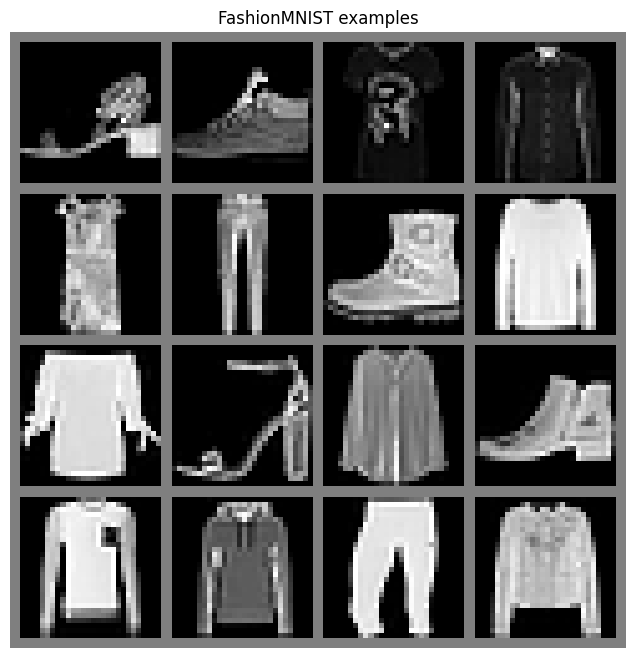

In [5]:
exmp_imgs = [train_set[i][0] for i in range(16)]
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [6]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")

In [7]:
def visualize_gradients(net, color="C0"):
    """
    Args:
        net: Object of class BaseNetwork
        color: Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {
        name: params.grad.data.view(-1).cpu().clone().numpy()
        for name, params in net.named_parameters()
        if "weight" in name
    }
    net.zero_grad()

    # Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index % columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(
        f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05
    )
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

In [8]:
from utils import set_seed
from model import BaseNetwork
from act_func import *
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

Using device cuda:0


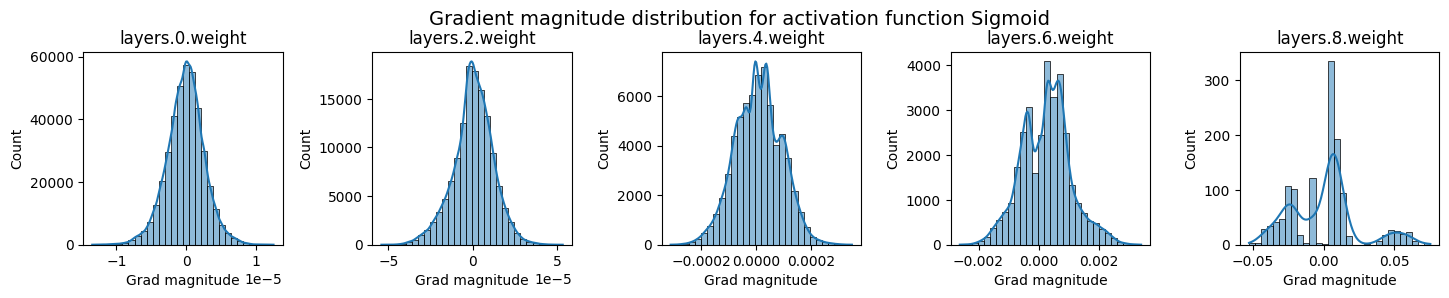

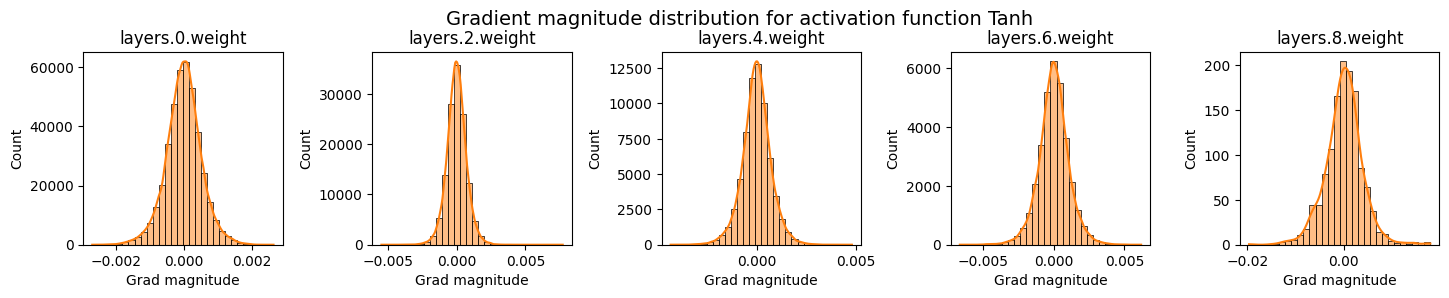

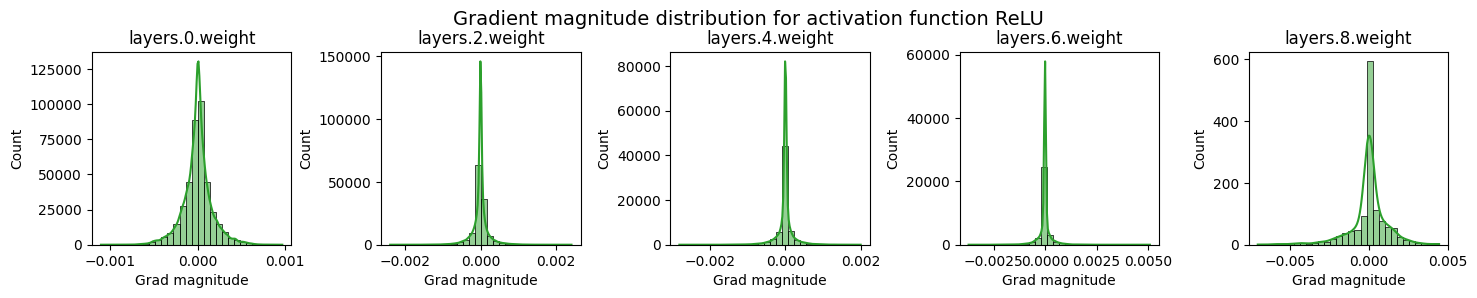

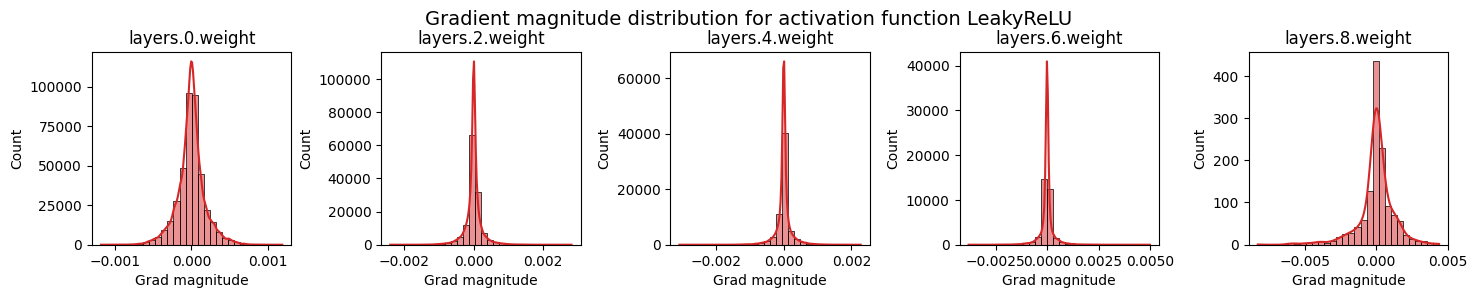

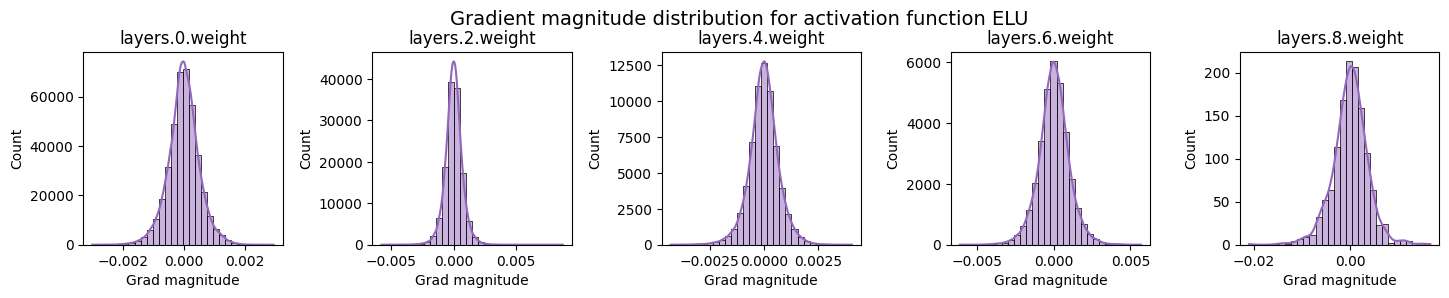

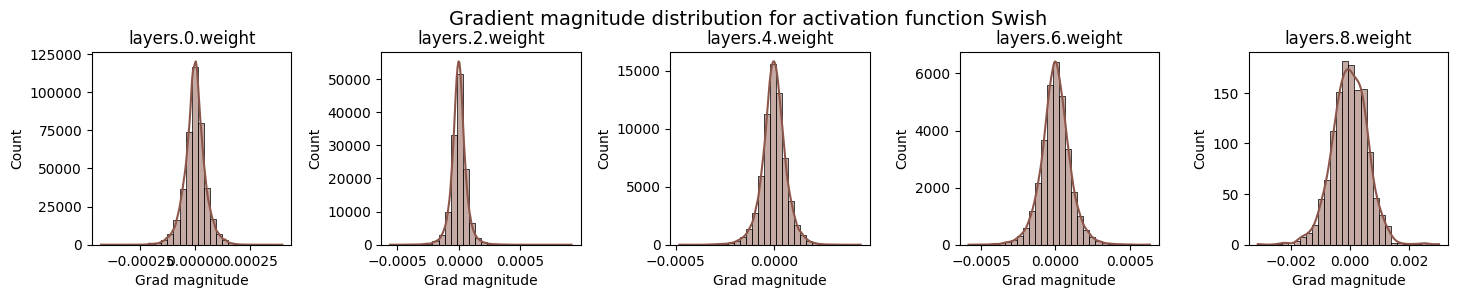

In [9]:
import warnings
warnings.filterwarnings("ignore")
# Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    # Setting the seed ensures that we have the same weight initialization for each activation function
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

### The sigmoid activation function shows a clearly undesirable behavior.